In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import gensim
import utils
from utils import QuoraDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch
import torch
import torch.nn as nn
from torch.nn.modules import dropout
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
import numpy as np
import tqdm

configs={
    "data_size": 1000,
    "max_sequence_length": 100,
    "sent_embedding_dim": 128,
    "word_embedding_dim": 300 
}
hparams = {
    'threshold': torch.Tensor([0.5]),  # threshold for determining similiarity
    'learning_rate': 1e-03,  # learning rate
    'epoch': 50,  # number of epochs
    'batch_size': 32,  # batch_size
    'hidden_dim': 100,  # number of hidden dimension
    'embedding_dim': 300,  # number of embedding dimension
    'dropout': 0.0,  # dropout
    'remove_stopwords': False,  # removes stopwords
    'stem_words': False,  # remove stem words 
    'simple': True,  # chooses simple or more complex model 
    'log_to_wandb': False,  # chooses to log to wandb or not
}

EMBEDDING_REQUIRES_GRAD = False
NUM_LAYERS = 1


In [ ]:
df=utils.read_data('/Users/srishtysuman/PycharmProjects/NaturalLanguageProcessing/quora-question-pairs/train.csv', configs["data_size"])
df=utils.preprocess(df, ['question1', 'question2'])
print(df)
word2vec=utils.load_pretrained_embeddings()
print(word2vec)
df, vocabulary, unique_words=utils.map_words(df, ['question1', 'question2'], word2vec.index_to_key)
print(df)
df=df.drop('id', axis=1)
print(df)

In [6]:
df

,qid1,qid2,question1,question2,is_duplicate,token_question1,token_question2
0,1,2,"[what, is, step, by, step, guide, to, invest, ...","[what, is, step, by, step, guide, to, invest, ...",0,"[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]"
1,3,4,"[what, is, story, of, kohinoor, kohinoor, diam...","[what, would, happen, if, indian, government, ...",0,"[7, 8]","[9, 10, 11, 12, 13, 8, 14]"
2,5,6,"[how, can, increase, speed, of, my, internet, ...","[how, can, internet, speed, be, increased, by,...",0,"[15, 16, 17, 18, 19, 20]","[17, 16, 21, 22, 23]"
3,7,8,"[why, am, mentally, very, lonely, how, can, so...","[find, remainder, when, [math]^{}[math], is, d...",0,"[24, 25, 26]","[27, 28, 29]"
4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,"[30, 31, 32, 33, 34, 35, 36, 37, 38]","[39, 9, 40, 34, 32]"
...,...,...,...,...,...,...,...
995,1985,1986,"[am, straight, student, but, have, no, motivat...","[my, fiancée, died, recently, and, it, pains, ...",0,"[2381, 92, 1717, 3337, 1040, 144, 1755, 3149]","[3338, 3336, 2174, 3339, 3340, 84, 3341]"
996,1987,1988,"[which, is, best, shares, to, purchase, and, s...","[in, sydney, which, company, would, be, best, ...",0,"[132, 3075, 2078, 3342, 1044, 273]","[2536, 62, 9, 132, 255, 866, 883, 505, 3343]"
997,1989,1990,"[and, my, girlfriends, private, partstouched, ...","[why, most, of, cosmetic, products, do, not, h...",0,"[3344, 952, 234]","[3345, 313, 1421, 3346]"
998,1991,1992,"[could, we, use, cherenkov, atmosphere, radiat...","[can, we, map, surface, and, subsurface, of, p...",1,"[583, 59, 3347, 3348, 3349, 3350, 668, 2115, 1...","[1837, 1389, 3352, 3351, 19, 3353, 3350, 506, ..."


In [16]:
df = df[df['token_question1'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
df = df[df['token_question2'].apply(lambda x: len(x) > 0)].reset_index(drop=True)
df

,qid1,qid2,question1,question2,is_duplicate,token_question1,token_question2
0,1,2,"[what, is, step, by, step, guide, to, invest, ...","[what, is, step, by, step, guide, to, invest, ...",0,"[1, 1, 2, 3, 4, 5, 6]","[1, 1, 2, 3, 4, 5]"
1,3,4,"[what, is, story, of, kohinoor, kohinoor, diam...","[what, would, happen, if, indian, government, ...",0,"[7, 8]","[9, 10, 11, 12, 13, 8, 14]"
2,5,6,"[how, can, increase, speed, of, my, internet, ...","[how, can, internet, speed, be, increased, by,...",0,"[15, 16, 17, 18, 19, 20]","[17, 16, 21, 22, 23]"
3,7,8,"[why, am, mentally, very, lonely, how, can, so...","[find, remainder, when, [math]^{}[math], is, d...",0,"[24, 25, 26]","[27, 28, 29]"
4,9,10,"[which, one, dissolve, in, water, quikly, suga...","[which, fish, would, survive, in, salt, water]",0,"[30, 31, 32, 33, 34, 35, 36, 37, 38]","[39, 9, 40, 34, 32]"
...,...,...,...,...,...,...,...
989,1985,1986,"[am, straight, student, but, have, no, motivat...","[my, fiancée, died, recently, and, it, pains, ...",0,"[2381, 92, 1717, 3337, 1040, 144, 1755, 3149]","[3338, 3336, 2174, 3339, 3340, 84, 3341]"
990,1987,1988,"[which, is, best, shares, to, purchase, and, s...","[in, sydney, which, company, would, be, best, ...",0,"[132, 3075, 2078, 3342, 1044, 273]","[2536, 62, 9, 132, 255, 866, 883, 505, 3343]"
991,1989,1990,"[and, my, girlfriends, private, partstouched, ...","[why, most, of, cosmetic, products, do, not, h...",0,"[3344, 952, 234]","[3345, 313, 1421, 3346]"
992,1991,1992,"[could, we, use, cherenkov, atmosphere, radiat...","[can, we, map, surface, and, subsurface, of, p...",1,"[583, 59, 3347, 3348, 3349, 3350, 668, 2115, 1...","[1837, 1389, 3352, 3351, 19, 3353, 3350, 506, ..."


In [18]:
question_list, question_indices, labels=utils.convert_data_to_tuples(df)
quora_dataset=QuoraDataset(question_list, question_indices, labels)
print(len(quora_dataset))
count=0
print(len(quora_dataset))
for sample in quora_dataset:
    print(count)
    count+=1
    print('question 1:', sample['q1'])
    print('question 2:', sample['q2'])
    print('tokens  q1:', sample['q1_token'])
    print('tokens  q2:', sample['q2_token'])
    print('labels    :', sample['labels'])

994
994
0
question 1: what is step by step guide to invest in share market in india
question 2: what is step by step guide to invest in share market in india
tokens  q1: [1, 1, 2, 3, 4, 5, 6]
tokens  q2: [1, 1, 2, 3, 4, 5]
labels    : 0
1
question 1: what is story of kohinoor kohinoor diamond
question 2: what is story of kohinoor kohinoor diamond
tokens  q1: [7, 8]
tokens  q2: [9, 10, 11, 12, 13, 8, 14]
labels    : 0
2
question 1: how can increase speed of my internet connection while using vpn
question 2: how can increase speed of my internet connection while using vpn
tokens  q1: [15, 16, 17, 18, 19, 20]
tokens  q2: [17, 16, 21, 22, 23]
labels    : 0
3
question 1: why am mentally very lonely how can solve it
question 2: why am mentally very lonely how can solve it
tokens  q1: [24, 25, 26]
tokens  q2: [27, 28, 29]
labels    : 0
4
question 1: which one dissolve in water quikly sugar salt methane and carbon di oxide
question 2: which one dissolve in water quikly sugar salt methane and c

KeyError: 994

In [19]:
train_split = 0.8
val_split = 0.2

dataset_size = len(quora_dataset)
indices = list(range(dataset_size))

split_train = int(train_split*dataset_size)
print(split_train)
shuffle_dataset = True
random_seed = 46
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, val_indices = indices[:split_train], indices[split_train:]
assert len(train_indices) + len(val_indices) == dataset_size

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

print('Training Set Size {}, Validation Set Size {},'.format(len(train_indices), len(val_indices)))

train_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=train_sampler, collate_fn=utils.collate)
val_dataloader = torch.utils.data.DataLoader(quora_dataset, batch_size=hparams['batch_size'], sampler=val_sampler, collate_fn=utils.collate)

embeddings=utils.get_embeddings_matrix(vocabulary, hparams["embedding_dim"], word2vec)
print(embeddings)
print(embeddings.shape)

795
Training Set Size 795, Validation Set Size 199,
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2061,  0.1084,  0.1104,  ...,  0.3027,  0.0605, -0.0228],
        [ 0.0383, -0.0229, -0.1387,  ..., -0.0500,  0.1719,  0.1533],
        ...,
        [ 0.1045,  0.0854,  0.1475,  ...,  0.0017,  0.0864, -0.0461],
        [-0.0520,  0.0225, -0.0447,  ...,  0.1445,  0.0957,  0.2539],
        [-0.3398,  0.1543, -0.0503,  ..., -0.0096, -0.0188,  0.1865]])
torch.Size([3356, 300])


In [21]:
class EmbeddingLSTMNet(nn.Module):
    def __init__(self, embedding_dim, hidden_cells, num_layers, embedding_rquires_grad, pretrained_weights, dropout):
        super(EmbeddingLSTMNet, self).__init__()
        self.device = 'cpu'
        self.embedding = nn.Embedding.from_pretrained(pretrained_weights)
        self.embedding.weight.requires_grad = embedding_rquires_grad

        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_cells, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_cells, hidden_cells)
        self.fc = nn.Linear(hidden_cells, hidden_cells)
        self.relu = nn.ReLU()        
        self.dropout = nn.Dropout(dropout)
               
    def forward(self, question, lengths):
        sorted_indices = np.flipud(np.argsort(lengths))
        lengths = np.flipud(np.sort(lengths))
        lengths = lengths.copy()
        
        ordered_questions = [torch.LongTensor(question[i]).to(self.device) for i in sorted_indices]
        ordered_questions = pad_sequence(ordered_questions, batch_first=True)

        embeddings = self.embedding(ordered_questions).to(self.device)

             
        embeddings = self.dropout(embeddings)
        # print("embeddings", embeddings)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        # print("packed", packed)
        out, (hn, cn) = self.lstm(packed)
        unpacked, unpacked_len = pad_packed_sequence(out, batch_first=True, total_length=int(lengths[0]))
        out = self.fc(self.relu(self.fc1(unpacked)))
    
        result = torch.FloatTensor(out.size())
        for i, encoded_matrix in enumerate(out):
            result[sorted_indices[i]] = encoded_matrix
        # print(result.shape)
        return result
    
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_lstm_net):
        super(SiameseNetwork, self).__init__()
        self.embedding = embedding_lstm_net   
        self.device = 'cpu'

    def manhattan_distance(self, q1, q2):
        return torch.exp(-torch.sum(torch.abs(q1 - q2), dim=0)).to(self.device)  
         
    def forward(self, q1, q2, q1_lengths, q2_lengths):
        output_q1 = self.embedding(q1, q1_lengths)

        

        output_q2 = self.embedding(q2, q2_lengths)

        similarity_score = torch.zeros(output_q1.size()[0]).to(self.device)
        print(q1_lengths)
        for index in range(output_q1.size()[0]):
            # Sequence lenghts are being used to index and retrieve the activations before the zero padding since they were not part of original question
            q1 = output_q1[index, q1_lengths[index] - 1, :]       
            q2 = output_q2[index, q2_lengths[index] - 1, :]   
            print(q1_lengths[index] - 1) 
            print(output_q1.shape)
            print(q1.shape)

            # print(self.manhattan_distance(q1, q2) )
            similarity_score[index] = self.manhattan_distance(q1, q2)     
        return similarity_score

embedding_net = EmbeddingLSTMNet(hparams['embedding_dim'], hparams['hidden_dim'], NUM_LAYERS, EMBEDDING_REQUIRES_GRAD, embeddings, hparams['dropout'])
model = SiameseNetwork(embedding_net)

for i, batch in enumerate(train_dataloader):
    q1, q2 = batch['q1_token'], batch['q2_token']
    q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
    y = torch.FloatTensor(batch['labels'])
    similarity = model(q1, q2, q1_len, q2_len)
    if i==0:
        break
    # print(similarity)

[5, 4, 8, 4, 3, 3, 2, 1, 2, 5, 7, 8, 4, 9, 6, 3, 6, 9, 3, 7, 6, 3, 4, 5, 6, 6, 4, 3, 12, 4, 3, 7]
4
torch.Size([32, 12, 100])
torch.Size([100])
3
torch.Size([32, 12, 100])
torch.Size([100])
7
torch.Size([32, 12, 100])
torch.Size([100])
3
torch.Size([32, 12, 100])
torch.Size([100])
2
torch.Size([32, 12, 100])
torch.Size([100])
2
torch.Size([32, 12, 100])
torch.Size([100])
1
torch.Size([32, 12, 100])
torch.Size([100])
0
torch.Size([32, 12, 100])
torch.Size([100])
1
torch.Size([32, 12, 100])
torch.Size([100])
4
torch.Size([32, 12, 100])
torch.Size([100])
6
torch.Size([32, 12, 100])
torch.Size([100])
7
torch.Size([32, 12, 100])
torch.Size([100])
3
torch.Size([32, 12, 100])
torch.Size([100])
8
torch.Size([32, 12, 100])
torch.Size([100])
5
torch.Size([32, 12, 100])
torch.Size([100])
2
torch.Size([32, 12, 100])
torch.Size([100])
5
torch.Size([32, 12, 100])
torch.Size([100])
8
torch.Size([32, 12, 100])
torch.Size([100])
2
torch.Size([32, 12, 100])
torch.Size([100])
6
torch.Size([32, 12, 100])


[5, 7, 5, 7, 5, 8, 7, 3, 5, 3, 3, 6, 2, 3, 4, 4, 9, 3, 4, 4, 3, 5, 5, 4, 5, 5, 9, 5, 2, 4, 6, 3]
4
torch.Size([32, 9, 100])
torch.Size([100])
6
torch.Size([32, 9, 100])
torch.Size([100])
4
torch.Size([32, 9, 100])
torch.Size([100])
6
torch.Size([32, 9, 100])
torch.Size([100])
4
torch.Size([32, 9, 100])
torch.Size([100])
7
torch.Size([32, 9, 100])
torch.Size([100])
6
torch.Size([32, 9, 100])
torch.Size([100])
2
torch.Size([32, 9, 100])
torch.Size([100])
4
torch.Size([32, 9, 100])
torch.Size([100])
2
torch.Size([32, 9, 100])
torch.Size([100])
2
torch.Size([32, 9, 100])
torch.Size([100])
5
torch.Size([32, 9, 100])
torch.Size([100])
1
torch.Size([32, 9, 100])
torch.Size([100])
2
torch.Size([32, 9, 100])
torch.Size([100])
3
torch.Size([32, 9, 100])
torch.Size([100])
3
torch.Size([32, 9, 100])
torch.Size([100])
8
torch.Size([32, 9, 100])
torch.Size([100])
2
torch.Size([32, 9, 100])
torch.Size([100])
3
torch.Size([32, 9, 100])
torch.Size([100])
3
torch.Size([32, 9, 100])
torch.Size([100])
2
t

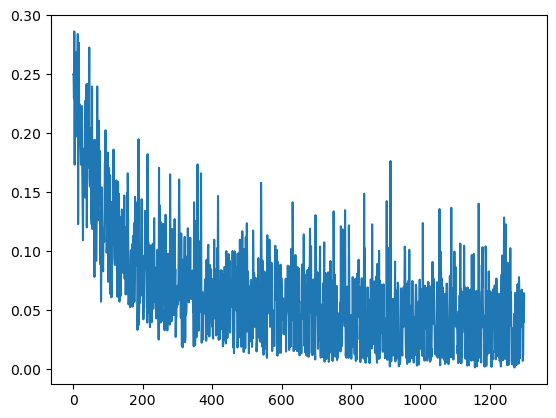

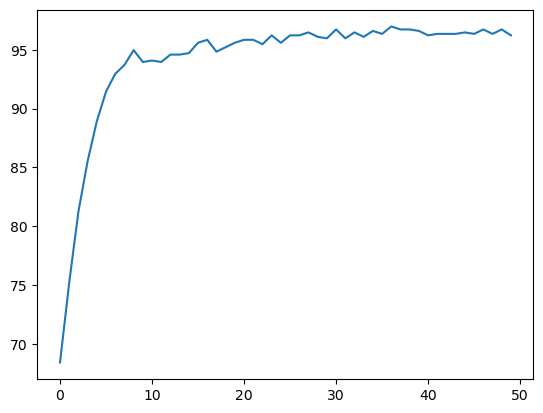

In [22]:
embedding_net = EmbeddingLSTMNet(hparams['embedding_dim'], hparams['hidden_dim'], NUM_LAYERS, EMBEDDING_REQUIRES_GRAD, embeddings, hparams['dropout'])
model = SiameseNetwork(embedding_net)

model.train()
loss_history=[]
accuracy_history=[]
for e in range(hparams["epoch"]):
    correct_total = 0
    losses=[]   
    optimizer=torch.optim.Adam(model.parameters(), lr=hparams["learning_rate"])
    for i, batch in enumerate(train_dataloader):
        q1, q2 = batch['q1_token'], batch['q2_token']
        q1_len, q2_len = batch['q1_lengths'], batch['q2_lengths']
        y = torch.FloatTensor(batch['labels'])
        optimizer.zero_grad()
        similarity = model(q1, q2, q1_len, q2_len)
        # print((similarity > hparams["threshold"]).float()*1)
        y_pred = (similarity > hparams["threshold"]).float() * 1
        # print((y_pred == y).sum().item())
        correct = (y_pred == y).sum().item()
        print(y_pred, y)
        correct_total += correct
        # print(nn.MSELoss()(similarity, y).item())
        loss = nn.MSELoss()(similarity, y)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()  
    loss_history.append(np.mean(loss_history))
    accuracy_history.append((correct_total/len(train_indices))*100)
    
import matplotlib.pyplot as plt
y=np.arange(len(loss_history))
plt.plot(y, loss_history)
plt.show()

y=np.arange(len(accuracy_history))
plt.plot(y, accuracy_history)
plt.show()
